In [59]:
import torch
import numpy as np
import struct
import matplotlib.pyplot as plt
torch.__version__

'2.4.0+cu121'

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

class MNIST_Dataset():
    def __init__(self, batch_size = 64):
        train_image_file = r"data\mnist-dataset\versions\1\train-images.idx3-ubyte"
        train_label_file = r"data\mnist-dataset\versions\1\train-labels.idx1-ubyte"  
        test_image_file = r"data\mnist-dataset\versions\1\t10k-images.idx3-ubyte"
        test_label_file = r"data\mnist-dataset\versions\1\t10k-labels.idx1-ubyte"

        self.train_images_raw = self.read_idx_images(train_image_file)
        self.train_labels_raw = self.read_idx_labels(train_label_file)

        self.test_images_raw = self.read_idx_images(test_image_file)
        self.test_labels_raw = self.read_idx_labels(test_label_file)

        self.train_images = torch.tensor(self.train_images_raw, dtype = torch.float32).unsqueeze(1) / 255.0
        self.train_labels = torch.tensor(self.train_labels_raw, dtype = torch.long)

        self.test_images = torch.tensor(self.test_images_raw, dtype = torch.float32).unsqueeze(1) / 255.0
        self.test_labels = torch.tensor(self.test_labels_raw, dtype = torch.long)

        self.batch_size = batch_size


    def read_idx_images(self, filename):
        with open(filename, 'rb') as f:
            # Đọc magic number, số lượng ảnh, chiều cao, chiều rộng
            magic, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
            # Đọc phần pixel data
            images = np.frombuffer(f.read(), dtype=np.uint8)
            images = images.reshape((num_images, rows, cols))
        return images

    def read_idx_labels(self, filename):
        with open(filename, 'rb') as f:
            # Đọc magic number, số lượng label
            magic, num_labels = struct.unpack(">II", f.read(8))
            labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

    def get_dataloader(self):
        train_dataset = TensorDataset(self.train_images, self.train_labels)
        test_dataset = TensorDataset(self.test_images, self.test_labels)

        train_dataloader = DataLoader(train_dataset, batch_size = self.batch_size, shuffle=True)
        test_dataloader = DataLoader(test_dataset, batch_size = self.batch_size, shuffle = True)
        
        return train_dataloader, test_dataloader
    
    def show_images(self, model_labels = None, num_images = 10):
        # Tạo figure
        plt.figure(figsize=(15, 3))  # (width, height) tính bằng inch

        for i in range(num_images):
            plt.subplot(1, num_images, i + 1)  # 1 dòng, num_images cột
            plt.imshow(self.test_images_raw[i].squeeze())  # squeeze() nếu ảnh có thêm 1 channel
            if model_labels is None:
                plt.title(f"Label: {self.test_labels_raw[i].item()}")
            else:
                plt.title(f"Real label: {self.test_labels_raw[i].item()} \n Model's label: {model_labels[i]}")
            plt.axis('off') 

        plt.tight_layout()
        plt.show()


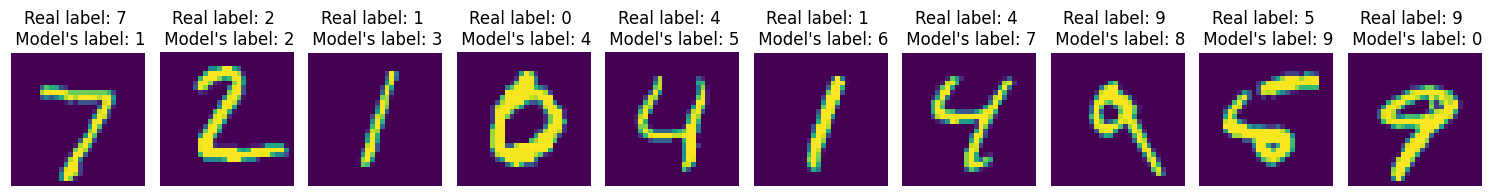

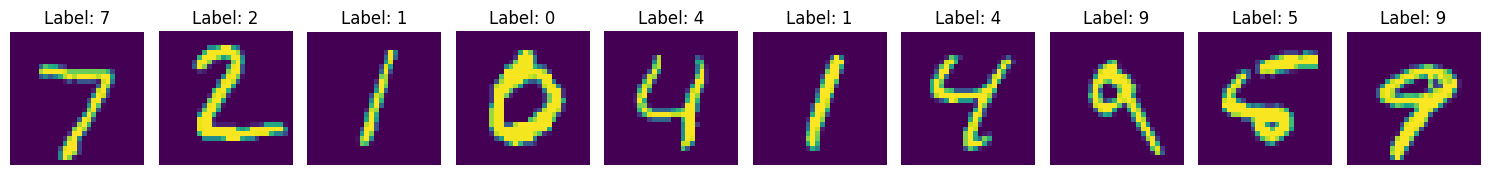

In [61]:
mnist = MNIST_Dataset()

mnist.show_images(model_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 0])
mnist.show_images()

In [62]:
train_dataloader, test_dataloader = mnist.get_dataloader()

In [88]:
import torch.nn as nn
import os
class MLP_classifier(nn.Module):
    def __init__(self, hidden_size1 = 1024, hidden_size2 = 1024):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, 10),
        )

    def forward(self, x):
        y = self.net(x)
        return y

    def save_model(self, path = "../pytorch_intro/MLP_ckpt/ckpt.pth"):
        dir_path = os.path.dirname(path)
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        torch.save(self.state_dict(), path)
        print(f"Model saved to {path}")


    def load_model(self, path = "../pytorch_intro/MLP_ckpt/ckpt.pth"):
        self.load_state_dict(torch.load(path, weights_only=True))
        self.to("cuda")
        self.eval()  # Đưa model về chế độ inference (tắt dropout, batchnorm nếu có)
        print(f"Model loaded from {path}")
    
        
    
class CNN_classfier(nn.Module):
    def __init__(self, hidden_size = 1024):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(out_channels=3, kernel_size=3), nn.ReLU(),
            nn.AvgPool2d(kernel_size=3, stride = 2), 
            nn.LazyConv2d(out_channels=3, kernel_size=3), nn.ReLU(),
            nn.Flatten(),
            nn.LazyLinear(hidden_size), nn.ReLU(),
            nn.LazyLinear(10)
        )
    
    def forward(self, x):
        y = self.net(x)
        return y
    
    def save_model(self, path = "../pytorch_intro/CNN_ckpt/ckpt.pth"):
        dir_path = os.path.dirname(path)
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        torch.save(self.state_dict(), path)
        print(f"Model saved to {path}")


    def load_model(self, path = "../pytorch_intro/CNN_ckpt/ckpt.pth"):
        self.load_state_dict(torch.load(path, weights_only=True))


        self.eval()  # Đưa model về chế độ inference (tắt dropout, batchnorm nếu có)
        print(f"Model loaded from {path}")





In [64]:
net = MLP_classifier()
net.load_model()

Model loaded from ../pytorch_intro/MLP_ckpt/ckpt.pth


In [65]:
net = CNN_classfier()
for batch_idx, (data, label) in enumerate(train_dataloader):
    y = net(data)
    print(y)
    break

tensor([[-1.9988e-02, -3.2399e-02,  3.2477e-02, -1.1824e-02,  3.6715e-02,
         -2.0656e-02,  5.2961e-02,  1.2813e-02, -7.4526e-03, -1.2879e-02],
        [-1.5264e-02, -3.2780e-02,  2.2474e-02, -5.0887e-03,  3.7222e-02,
         -2.1849e-02,  5.7937e-02,  1.5290e-02,  1.6446e-03, -5.0631e-03],
        [-2.1890e-02, -3.5264e-02,  2.2336e-02, -1.0489e-02,  2.4403e-02,
         -1.7211e-02,  5.2808e-02, -5.7282e-03, -5.6290e-03, -4.2139e-03],
        [-7.5076e-03, -2.9914e-02,  3.4655e-02, -2.3809e-02,  2.4607e-02,
         -1.9467e-02,  6.0055e-02,  6.6874e-03, -1.4032e-03, -1.7193e-02],
        [-7.8798e-03, -3.4258e-02,  3.4487e-02, -1.2396e-02,  2.8105e-02,
         -2.5168e-02,  4.6002e-02,  1.5858e-02, -9.6645e-05, -1.0454e-02],
        [-2.0829e-02, -3.2770e-02,  3.6707e-02, -1.1163e-02,  2.2330e-02,
         -1.8153e-02,  5.1077e-02,  1.1663e-02, -2.4565e-03, -1.1024e-02],
        [-1.6709e-02, -3.0358e-02,  3.6412e-02, -9.4564e-03,  4.1218e-02,
         -1.6256e-02,  5.9363e-0

In [66]:
def training_step(model, batch, loss_fn, optimizer, device):
    X = batch[0]
    y = batch[1]
    X = X.to(device)
    y = y.to(device)

    y_hat = model(X)
    l = loss_fn(y_hat, y)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()

    training_loss = l.item()
    return training_loss

def validation_step(model, batch, loss_fn, device):
    X = batch[0]
    y = batch[1]
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad():
        y_hat = model(X)
        l = loss_fn(y_hat, y)
    valid_loss = l.item()
    return valid_loss

def accuracy(model, test_dataloader, device, maximum_test = 100):
    true_cnt = 0
    total = 0
    for batch_idx, (X, y) in enumerate(test_dataloader):
        X = X.to(device)
        y = y.to(device)
        with torch.no_grad():
            y_hat = model(X)
        choice = torch.argmax(y_hat, dim = -1)

        # for index, (model_choice, true_choice) in enumerate((choice, y)):
        for i in range(len(y)):
            true_choice = y[i]
            model_choice = choice[i]
            if model_choice == true_choice:
                true_cnt+=1
            total += 1
        if total > maximum_test:
            break
    return 1.0 * true_cnt / total


In [67]:
model = CNN_classfier()
model.to("cuda")
accuracy(model, test_dataloader, "cuda")

0.09375

In [ ]:
def training(model, device = "cuda", num_epochs = 50):
    loss = nn.CrossEntropyLoss()
    optim = torch.optim.SGD(model.parameters(), lr = 0.001)
    best_acc = 0.0
    for i in range(num_epochs):
        training_loss, validation_loss = 0, 0
        for batch_idx, batch in enumerate(train_dataloader):
            training_loss += training_step(model, batch, loss, optim, device)
        for batch_idx, batch in enumerate(test_dataloader):
            validation_loss += validation_step(model, batch, loss, device)
        acc = accuracy(model, test_dataloader, device, 2000)
        print(f"Epoch: {i + 1}, Training Loss: {training_loss}, Validation Loss: {validation_loss}, Accuracy: {acc}")
        if acc > best_acc:
            best_acc = acc
            model.save_model()

In [70]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNN_classfier()
model.to(device)
training(model)

model = MLP_classifier()
model.to(device)
training(model)


Epoch: 1, Training Loss: 2155.2528471946716, Validation Loss: 359.5131034851074, Accuracy: 0.2041015625
Model saved to ../pytorch_intro/CNN_ckpt/ckpt.pth
Epoch: 2, Training Loss: 2133.4457700252533, Validation Loss: 352.8526327610016, Accuracy: 0.275390625
Model saved to ../pytorch_intro/CNN_ckpt/ckpt.pth
Epoch: 3, Training Loss: 2016.5045130252838, Validation Loss: 301.8206133842468, Accuracy: 0.607421875
Model saved to ../pytorch_intro/CNN_ckpt/ckpt.pth
Epoch: 4, Training Loss: 1175.3883514404297, Validation Loss: 104.65252554416656, Accuracy: 0.85107421875
Model saved to ../pytorch_intro/CNN_ckpt/ckpt.pth
Epoch: 5, Training Loss: 518.8217205107212, Validation Loss: 68.56727693974972, Accuracy: 0.88037109375
Model saved to ../pytorch_intro/CNN_ckpt/ckpt.pth
Epoch: 6, Training Loss: 405.0803371220827, Validation Loss: 59.3696324378252, Accuracy: 0.89501953125
Model saved to ../pytorch_intro/CNN_ckpt/ckpt.pth
Epoch: 7, Training Loss: 360.8702780306339, Validation Loss: 54.3156231343746

In [107]:
test_model = MLP_classifier()
test_model.load_model()
accuracy(model, train_dataloader, device, 2000)

Model loaded from ../pytorch_intro/MLP_ckpt/ckpt.pth


0.92333984375

In [ ]:
test_images = mnist.test_images_raw[:15]
test_images = torch.tensor(test_images, dtype = torch.float32, device = device).unsqueeze(1)
y_hat = model(test_images)

In [112]:
model_choice = torch.argmax(y_hat, dim = -1).cpu().numpy()

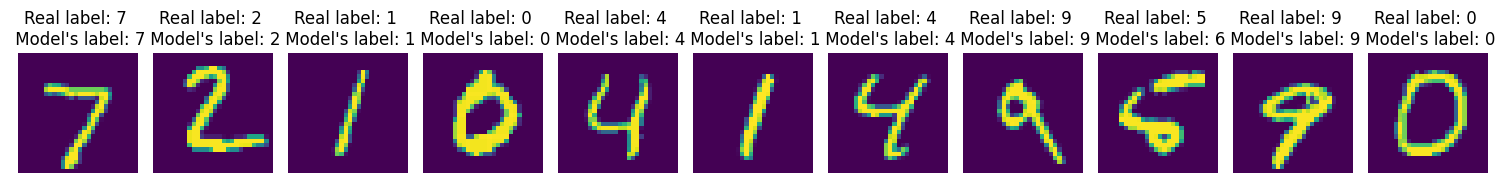

In [116]:
mnist.show_images(model_labels = model_choice, num_images=11)